# Day 3
batch size 256 lr 1e-3, normed weighted, rotated, cartesian, split ny jet mult (2)

### Import modules

In [ ]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

## Options

In [ ]:
nJets = '2'
inputPipe, outputPipe = getPreProcPipes(normIn=True)
classModel = 'modelSwish'
varSet = "filtered_rot_cart_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':30, 'compileArgs':compileArgs}

## Import data

In [ ]:
trainData = h5py.File(dirLoc + 'train_' + nJets + '.hdf5', "r+")
valData = h5py.File(dirLoc + 'val_' + nJets + '.hdf5', "r+")

## Determine LR

In [ ]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [4]:
compileArgs['lr'] = 1e-3

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.000183191714592
2 New best found: 0.00016132705533
3 New best found: 0.000157272275863
4 New best found: 0.000157250565288
5 New best found: 0.000146194978298
6 New best found: 0.000141604157241
7 New best found: 0.000141006016491
8 New best found: 0.000137478889445
9 New best found: 0.00013306593164
10 New best found: 0.000132076074558
11 New best found: 0.000130028797717
12 New best found: 0.000129204436718
13 New best found: 0.000128588223006
14 New best found: 0.000128285517756
15 New best found: 0.000128174880638
17 New best found: 0.000126528308754
19 New best found: 0.000122546689889
24 New best found: 0.000121999158664
25 New best found: 0.000121683305192
26 New best found: 0.000120814298306
27 New best found: 0.000120289260376
28 New best found: 0.000119659579668
29 New best found: 0.000119603450634
30 New best found: 0.000119492539467
31 New best foun

17 New best found: 0.00013615103068
20 New best found: 0.000134738922844
22 New best found: 0.000130779433556
23 New best found: 0.000130650814684
24 New best found: 0.000129574380764
27 New best found: 0.00012849914949
32 New best found: 0.000128000781468
36 New best found: 0.000127450713999
40 New best found: 0.000125394959872
42 New best found: 0.000125336202902
45 New best found: 0.000124915979174
47 New best found: 0.000124341003945
49 New best found: 0.000123602965011
58 New best found: 0.000123562184932
60 New best found: 0.000123476345705
Early stopping after 160 epochs
Score is: {'loss': 0.00012347634570474822, 'AUC': 0.093610283137082417, 'wAUC': 0.076913462383763065}
Fold took 37.908s

Running fold 8 / 10
1 New best found: 0.000186857473453
2 New best found: 0.000163933151812
3 New best found: 0.000161155128461
4 New best found: 0.000149867814342
5 New best found: 0.000141953380496
6 New best found: 0.000140997782433
7 New best found: 0.000139478273582
8 New best found: 0.00

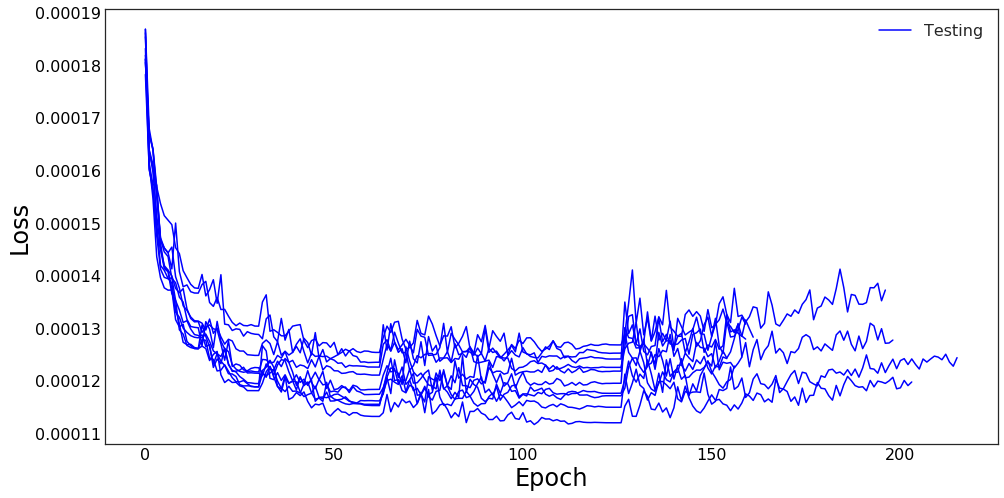

Mean wAUC = 0.072 +- 0.001
______________________________________



In [5]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, patience=100, cosAnnealMult=2, trainOnWeights=True, maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [6]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [7]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 9 with loss = 0.000111693933471
Model 1 is 8 with loss = 0.00011463385151
Model 2 is 7 with loss = 0.000115541801238
Model 3 is 0 with loss = 0.000115783305351
Model 4 is 2 with loss = 0.000117392015909
Model 5 is 5 with loss = 0.000118171088961
Model 6 is 3 with loss = 0.000121087625716
Model 7 is 1 with loss = 0.000121879447012
Model 8 is 6 with loss = 0.000123476345705
Model 9 is 4 with loss = 0.000124920100839


## Response on development data

In [8]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000280202092342s per sample

Predicting batch 2 out of 10
Prediction took 0.000151502395974s per sample

Predicting batch 3 out of 10
Prediction took 0.000155171429511s per sample

Predicting batch 4 out of 10
Prediction took 0.000192716029658s per sample

Predicting batch 5 out of 10
Prediction took 0.000162076325683s per sample

Predicting batch 6 out of 10
Prediction took 0.000163605959148s per sample

Predicting batch 7 out of 10
Prediction took 0.000165253821147s per sample

Predicting batch 8 out of 10
Prediction took 0.000153709439888s per sample

Predicting batch 9 out of 10
Prediction took 0.000151839185608s per sample

Predicting batch 10 out of 10
Prediction took 0.000148515009297s per sample



In [9]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

Training ROC AUC: unweighted 0.921722555278, weighted 0.946736710253


## Response on val data

In [10]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000155145307546s per sample

Predicting batch 2 out of 10
Prediction took 0.000150776763264s per sample

Predicting batch 3 out of 10
Prediction took 0.000153682217115s per sample

Predicting batch 4 out of 10
Prediction took 0.000154779336931s per sample

Predicting batch 5 out of 10
Prediction took 0.000169899938519s per sample

Predicting batch 6 out of 10
Prediction took 0.000188760146201s per sample

Predicting batch 7 out of 10
Prediction took 0.000154391393261s per sample

Predicting batch 8 out of 10
Prediction took 0.000168859218729s per sample

Predicting batch 9 out of 10
Prediction took 0.000174762133894s per sample

Predicting batch 10 out of 10
Prediction took 0.000176387490897s per sample



In [11]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData), getFeature('pred', valData)),
                                                           roc_auc_score(getFeature('targets', valData), getFeature('pred', valData), sample_weight=getFeature('weights', valData)))

Testing ROC AUC: unweighted 0.917448391537, weighted 0.93053168924


## Evaluation

### Import in dataframe

In [12]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [13]:
valData = convertToDF(valData)

14509 candidates loaded


In [14]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### MVA distributions

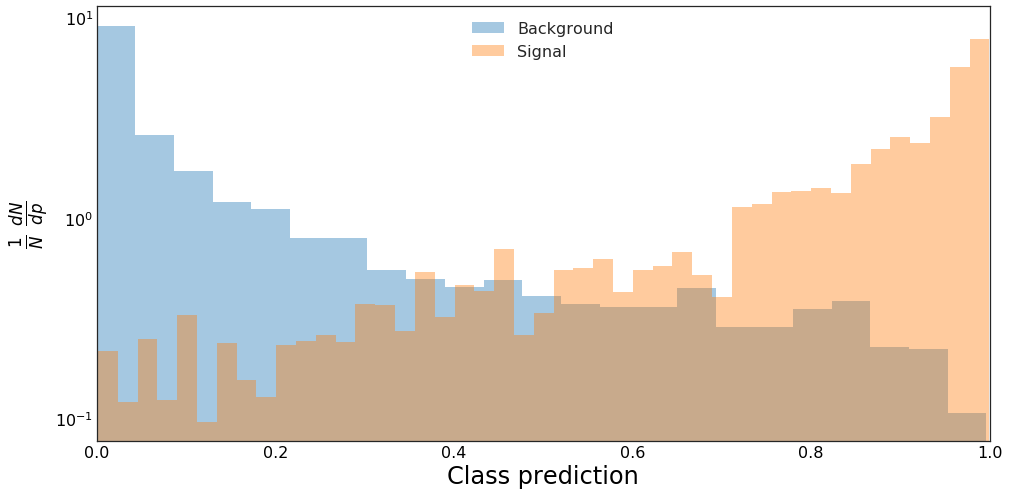

In [15]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [16]:
amsScan(valData)

[0.95911794900894165, 1.1277129279325375]


[0.5858607297429708,
 0.5144090029695029,
 0.3270069735050935,
 0.5412941666739808,
 nan,
 1.0285458983846054,
 0.5271226582236025,
 0.36529981153102575,
 0.6639580483907994,
 0.5733150212917228,
 0.47095751554685494,
 0.4318954212818407,
 0.35937990026791267,
 nan,
 0.7610462875124278,
 0.4903903135478687,
 0.3241200049066376,
 1.092930074652469,
 0.3047343906863384,
 0.6245664642879819,
 0.3020111669981746,
 1.0345214167553496,
 nan,
 0.3195298289234707,
 0.5769862879916988,
 0.6574577989459561,
 0.8711849621113572,
 0.8169293149589812,
 0.6472436498717181,
 0.29598379857774154,
 0.7607111414904788,
 0.2989526787563641,
 0.9433480377328863,
 0.5488323634531911,
 0.836205255003417,
 0.3779244492094753,
 0.7592886753530009,
 0.620134912143516,
 0.38734862069686593,
 0.34467755043721776,
 0.3001536294366832,
 1.0372607082444674,
 0.6353250014573549,
 0.5137183189297752,
 0.9066524579788096,
 0.6207352363585316,
 0.7728178151083862,
 0.29821059451631937,
 0.489640494377904,
 0.7623178642

In [17]:
def scoreTest(ensemble, weights, nJets):
    testData = h5py.File(dirLoc + 'testing_' + nJets + '.hdf5', "r+")
    batchEnsemblePredict(ensemble, weights, testData, ensembleSize=10, verbose=1)

def saveTest(cut, name, nJets):
    testData = h5py.File(dirLoc + 'testing_' + nJets + '.hdf5', "r+")
    
    data = pandas.DataFrame()
    data['EventId'] = getFeature('EventId', testData)
    data['pred_class'] = getFeature('pred', testData)
    
    data['Class'] = 'b'
    data.loc[data.pred_class >= cut, 'Class'] = 's'

    data.sort_values(by=['pred_class'], inplace=True)
    data['RankOrder']=range(1, len(data)+1)
    data.sort_values(by=['EventId'], inplace=True)

    print dirLoc + name + '_test.csv'
    data.to_csv(dirLoc + name + '_test.csv', columns=['EventId', 'RankOrder', 'Class'], index=False)

In [18]:
scoreTest(ensemble, weights, nJets)

Predicting batch 1 out of 10
Prediction took 0.000161971574213s per sample

Predicting batch 2 out of 10
Prediction took 0.000148493234292s per sample

Predicting batch 3 out of 10
Prediction took 0.000154633856442s per sample

Predicting batch 4 out of 10
Prediction took 0.000146726914872s per sample

Predicting batch 5 out of 10
Prediction took 0.000152319366359s per sample

Predicting batch 6 out of 10
Prediction took 0.000153105538707s per sample

Predicting batch 7 out of 10
Prediction took 0.000150671266105s per sample

Predicting batch 8 out of 10
Prediction took 0.000152679130808s per sample

Predicting batch 9 out of 10
Prediction took 0.000151258869347s per sample

Predicting batch 10 out of 10
Prediction took 0.000148962966329s per sample



In [ ]:
saveTest(0.9629805684089661, 'Day_2_Basic_Features_256_1e-3_swish_mult2_200E_normedweighted_rot_cart')

!kaggle competitions submit -c higgs-boson -f ../Data/Day_2_Basic_Features_256_1e-3_swish_mult2_200E_normedweighted_rot_cart_test.csv -m"Day2"